In [1]:
import numpy as np
import pathlib
from os.path import join, isfile
from hyperspace import hyperdrive
from stable_baselines.common import make_vec_env
from stable_baselines import PPO2
from stable_baselines.common.callbacks import EvalCallback
from stable_baselines.common.vec_env import DummyVecEnv
import datetime
import os
import yaml
import rl

env_name = 'AbstractConveyor'


path = pathlib.Path().absolute()


def objective(params):
    """
    Objective function to be minimized.

    Parameters
    ----------
    * params [list, len(params)=n_hyperparameters]
        Settings of each hyperparameter for a given optimization iteration.
        - Controlled by hyperspaces's hyperdrive function.
        - Order preserved from list passed to hyperdrive's hyperparameters argument.
     """
    config_path = join(path, 'rl', 'config', '{}.yml'.format(env_name))
    with open(config_path) as f:
        config = yaml.safe_load(f)
        print('model loaded from path: {}'.format(config_path))
    
    #set the parameters
    prfd, wsag, fr, nria, nrfeq, nrfc = params
    config['environment']['positive_reward_for_divert'] = prfd
    config['environment']['wrong_sup_at_goal'] = wsag
    config['environment']['flooding_reward'] = fr
    config['environment']['neg_reward_ia'] = nria
    config['environment']['negative_reward_for_empty_queue'] = nrfeq
    config['environment']['negative_reward_for_cycle'] = nrfc
    
    print('Current settings for the config: \n\npositive_reward_for_divert \t:\t{}\nwrong_sup_at_goal\t\t:\t{}\n\
flooding_reward\t\t\t:\t{}\nneg_reward_ia\t\t\t:\t{}\nnegative_reward_for_empty_queue\t:\t{}\n\
negative_reward_for_cycle\t:\t{}\n'.format(prfd, wsag, fr, nria, nrfeq, nrfc))
    
    #GET MODEL CONFIG
    model_config = config['models']['PPO2']
    policy = config['main']['policy']
    n_workers = config['main']['n_workers']
    n_steps = config['main']['n_steps']
    n_eval = (n_steps / 8)/10
    
    # load environment with config variables
    env_obj = getattr(rl.environments, env_name)
    env = env_obj(config)
    
    # multiprocess environment
    env_8 = make_vec_env(lambda: env, n_envs=n_workers)
    
    #define folder and path
    now = datetime.datetime.now()
    folder ='{}{}{}_{}{}'.format(now.year, str(now.month).zfill(2), str(now.day).zfill(2), str(now.hour).zfill(2), str(now.minute).zfill(2))
    specified_path = join(path, 'rl', 'trained_models', env_name, folder)
    print('Results stored in: {}'.format(specified_path))
    
    # callback for evaluation
    eval_callback = EvalCallback(env, best_model_save_path=specified_path,
                                 log_path=specified_path, eval_freq=n_eval,
                                 n_eval_episodes=5, verbose=0,
                                 deterministic=False, render=False)

    model = PPO2(policy, env=env_8, tensorboard_log=specified_path, **model_config)
    
    #LEARN MODEL
    model.learn(total_timesteps=n_steps, tb_log_name='{}_{}_{}_{}_{}_{}'.format(prfd, wsag, fr, nria, nrfeq, nrfc),
                        callback=eval_callback)
    model_path = join(specified_path, 'model_{}_{}_{}_{}_{}_{}.zip'.format(prfd, wsag, fr, nria, nrfeq, nrfc))
    model.save(model_path)
    
    #test
    best_modelpath = join(specified_path, 'best_model.zip')
    test_model = PPO2.load(best_modelpath, env=DummyVecEnv([lambda: env]))
    
    #run test of the model
    episodes = 10
    results = {}
    results['cycle_count'] = 0
    results['idle_time'] = 0
    for episode in range(episodes):
        # Run an episode
        state = env.reset()
        done = False
        meta_data = []
        while not done:
            action, _ = test_model.predict(state, deterministic=False)
            state, reward, done, _ = env.step(action)
            if done:
                results['cycle_count'] += env.cycle_count
                results['idle_time'] += sum(env.idle_times_operator.values())
    
    return -1*((results['cycle_count'] + results['idle_time']) /episodes)
    
def main():
    #hparams = [(low, high),        #per var
    #           (low, high)]
    hparams = [(0, 10), #positive_reward_for_divert
               (0, 10), #wrong_sup_at_goal
               (0, 10), #flooding_reward
               (0, 10), #neg_reward_ia
               (0, 10), #negative_reward_for_empty_queue
               (0, 10)] #negative_reward_for_cycle
    
    #define path for the results
    hyperdive_results = join(path, 'rl', 'hyper_parameter', env_name)
    
    #make folder if not exist
    try:
        os.mkdir(hyperdive_results)
    except:
        pass
    
    #run the hyper drive optimization
    hyperdrive(objective=objective,
               hyperparameters=hparams,
               results_path=hyperdive_results,
               checkpoints_path=hyperdive_results,
               model="GP",
               n_iterations=50,
               verbose=True,
               random_state=42)

if __name__=='__main__':
     main()

INFO:tensorflow:TensorFlow


INFO:tensorflow:TensorFlow


loading checkpoint for rank 0
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0090
Function value obtained: 503.4000
Current minimum: 503.4000
Iteration No: 2 started. Evaluating function at random point.
model loaded from path: D:\Drive\git\RL\rl\config\AbstractConveyor.yml
Current settings for the config: 

positive_reward_for_divert 	:	9
wrong_sup_at_goal		:	5
    flooding_reward			:	9
neg_reward_ia			:	8
negative_reward_for_empty_queue	:	7
    negative_reward_for_cycle	:	5

Results stored in: D:\Drive\git\RL\rl\trained_models\AbstractConveyor\20201123_2104


c:\users\_vinc\appdata\local\programs\python\python37\lib\site-packages\skopt\space\space.py:502: RuntimeWarning: divide by zero encountered in log10
  np.log10(self.low) / self.log_base,
c:\users\_vinc\appdata\local\programs\python\python37\lib\site-packages\skopt\space\space.py:504: RuntimeWarning: divide by zero encountered in log10
  np.log10(self.low) / self.log_base)


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 127.2893
Function value obtained: -507.9000
Current minimum: -507.9000
Iteration No: 3 started. Evaluating function at random point.
model loaded from path: D:\Drive\git\RL\rl\config\AbstractConveyor.yml
Current settings for the config: 

positive_reward_for_divert 	:	7
wrong_sup_at_goal		:	6
    flooding_reward			:	5
neg_reward_ia			:	8
negative_reward_for_empty_queue	:	4
    negative_reward_for_cycle	:	8

Results stored in: D:\Drive\git\RL\rl\trained_models\AbstractConveyor\20201123_2106
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 136.5459
Function value obtained: -419.4000
Current minimum: -507.9000
Iteration No: 4 started. Evaluating function at random point.
model loaded from path: D:\Drive\git\RL\rl\config\AbstractConveyor.yml
Current settings for the config: 

positive_reward_for_divert 	:	10
wrong_sup_at_goal		:	4
    flooding_reward			:	10
neg_reward_ia			:	8
negative_reward_for_empty_q

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 149.4347
Function value obtained: -414.2000
Current minimum: -725.6000
Iteration No: 18 started. Searching for the next optimal point.
model loaded from path: D:\Drive\git\RL\rl\config\AbstractConveyor.yml
Current settings for the config: 

positive_reward_for_divert 	:	10
wrong_sup_at_goal		:	5
    flooding_reward			:	9
neg_reward_ia			:	7
negative_reward_for_empty_queue	:	9
    negative_reward_for_cycle	:	9

Results stored in: D:\Drive\git\RL\rl\trained_models\AbstractConveyor\20201123_2140
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 138.7184
Function value obtained: -436.0000
Current minimum: -725.6000
Iteration No: 19 started. Searching for the next optimal point.
model loaded from path: D:\Drive\git\RL\rl\config\AbstractConveyor.yml
Current settings for the config: 

positive_reward_for_divert 	:	10
wrong_sup_at_goal		:	9
    flooding_reward			:	5
neg_reward_ia			:	5

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 140.8518
Function value obtained: -619.2000
Current minimum: -725.6000
Iteration No: 33 started. Searching for the next optimal point.
model loaded from path: D:\Drive\git\RL\rl\config\AbstractConveyor.yml
Current settings for the config: 

positive_reward_for_divert 	:	10
wrong_sup_at_goal		:	4
    flooding_reward			:	5
neg_reward_ia			:	4
negative_reward_for_empty_queue	:	8
    negative_reward_for_cycle	:	4

Results stored in: D:\Drive\git\RL\rl\trained_models\AbstractConveyor\20201123_2214
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 141.6998
Function value obtained: -432.6000
Current minimum: -725.6000
Iteration No: 34 started. Searching for the next optimal point.
model loaded from path: D:\Drive\git\RL\rl\config\AbstractConveyor.yml
Current settings for the config: 

positive_reward_for_divert 	:	4
wrong_sup_at_goal		:	5
    flooding_reward			:	8
neg_reward_ia			:	7


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 136.4603
Function value obtained: -526.2000
Current minimum: -873.5000
Iteration No: 48 started. Searching for the next optimal point.
model loaded from path: D:\Drive\git\RL\rl\config\AbstractConveyor.yml
Current settings for the config: 

positive_reward_for_divert 	:	4
wrong_sup_at_goal		:	6
    flooding_reward			:	4
neg_reward_ia			:	7
negative_reward_for_empty_queue	:	6
    negative_reward_for_cycle	:	10

Results stored in: D:\Drive\git\RL\rl\trained_models\AbstractConveyor\20201123_2248
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 134.2983
Function value obtained: -561.2000
Current minimum: -873.5000
Iteration No: 49 started. Searching for the next optimal point.
model loaded from path: D:\Drive\git\RL\rl\config\AbstractConveyor.yml
Current settings for the config: 

positive_reward_for_divert 	:	4
wrong_sup_at_goal		:	4
    flooding_reward			:	9
neg_reward_ia			:	7


c:\users\_vinc\appdata\local\programs\python\python37\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 129.1848
Function value obtained: -589.0000
Current minimum: -873.5000
Iteration No: 50 started. Searching for the next optimal point.
model loaded from path: D:\Drive\git\RL\rl\config\AbstractConveyor.yml
Current settings for the config: 

positive_reward_for_divert 	:	10
wrong_sup_at_goal		:	5
    flooding_reward			:	9
neg_reward_ia			:	7
negative_reward_for_empty_queue	:	7
    negative_reward_for_cycle	:	4

Results stored in: D:\Drive\git\RL\rl\trained_models\AbstractConveyor\20201123_2252
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 129.3033
Function value obtained: -687.0000
Current minimum: -873.5000
model loaded from path: D:\Drive\git\RL\rl\config\AbstractConveyor.yml
Current settings for the config: 

positive_reward_for_divert 	:	10
wrong_sup_at_goal		:	8
    flooding_reward			:	10
neg_reward_ia			:	8
negative_reward_for_empty_queue	:	8
    negative_reward_for_cy

In [15]:
from hyperspace.kepler.data_utils import load_results
from hyperspace.kepler.plots import plot_convergence

path = pathlib.Path().absolute()
path_ = join(path, 'rl', 'hyper_parameter')
results = load_results(path_, sort=True)



best_result

          fun: -873.5
    func_vals: array([ 658.6,  503.4, -507.9, -419.4, -725.6, -425.7, -509. , -480.1,
       -437.9, -460.4, -692.4, -554.9, -654.8, -710.2, -440.8, -506.9,
       -532.7, -414.2, -436. , -499.4, -599.2, -420.6, -436.8, -580.2,
       -511. , -410.3, -524.5, -417.2, -516.6, -401. , -457.5, -460.8,
       -619.2, -432.6, -751.9, -873.5, -488.7, -432.8, -634.2, -422.5,
       -502.1, -581.8, -586.5, -466.8, -506.6, -572. , -478.9, -526.2,
       -561.2, -589. , -687. , -420. ])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, r

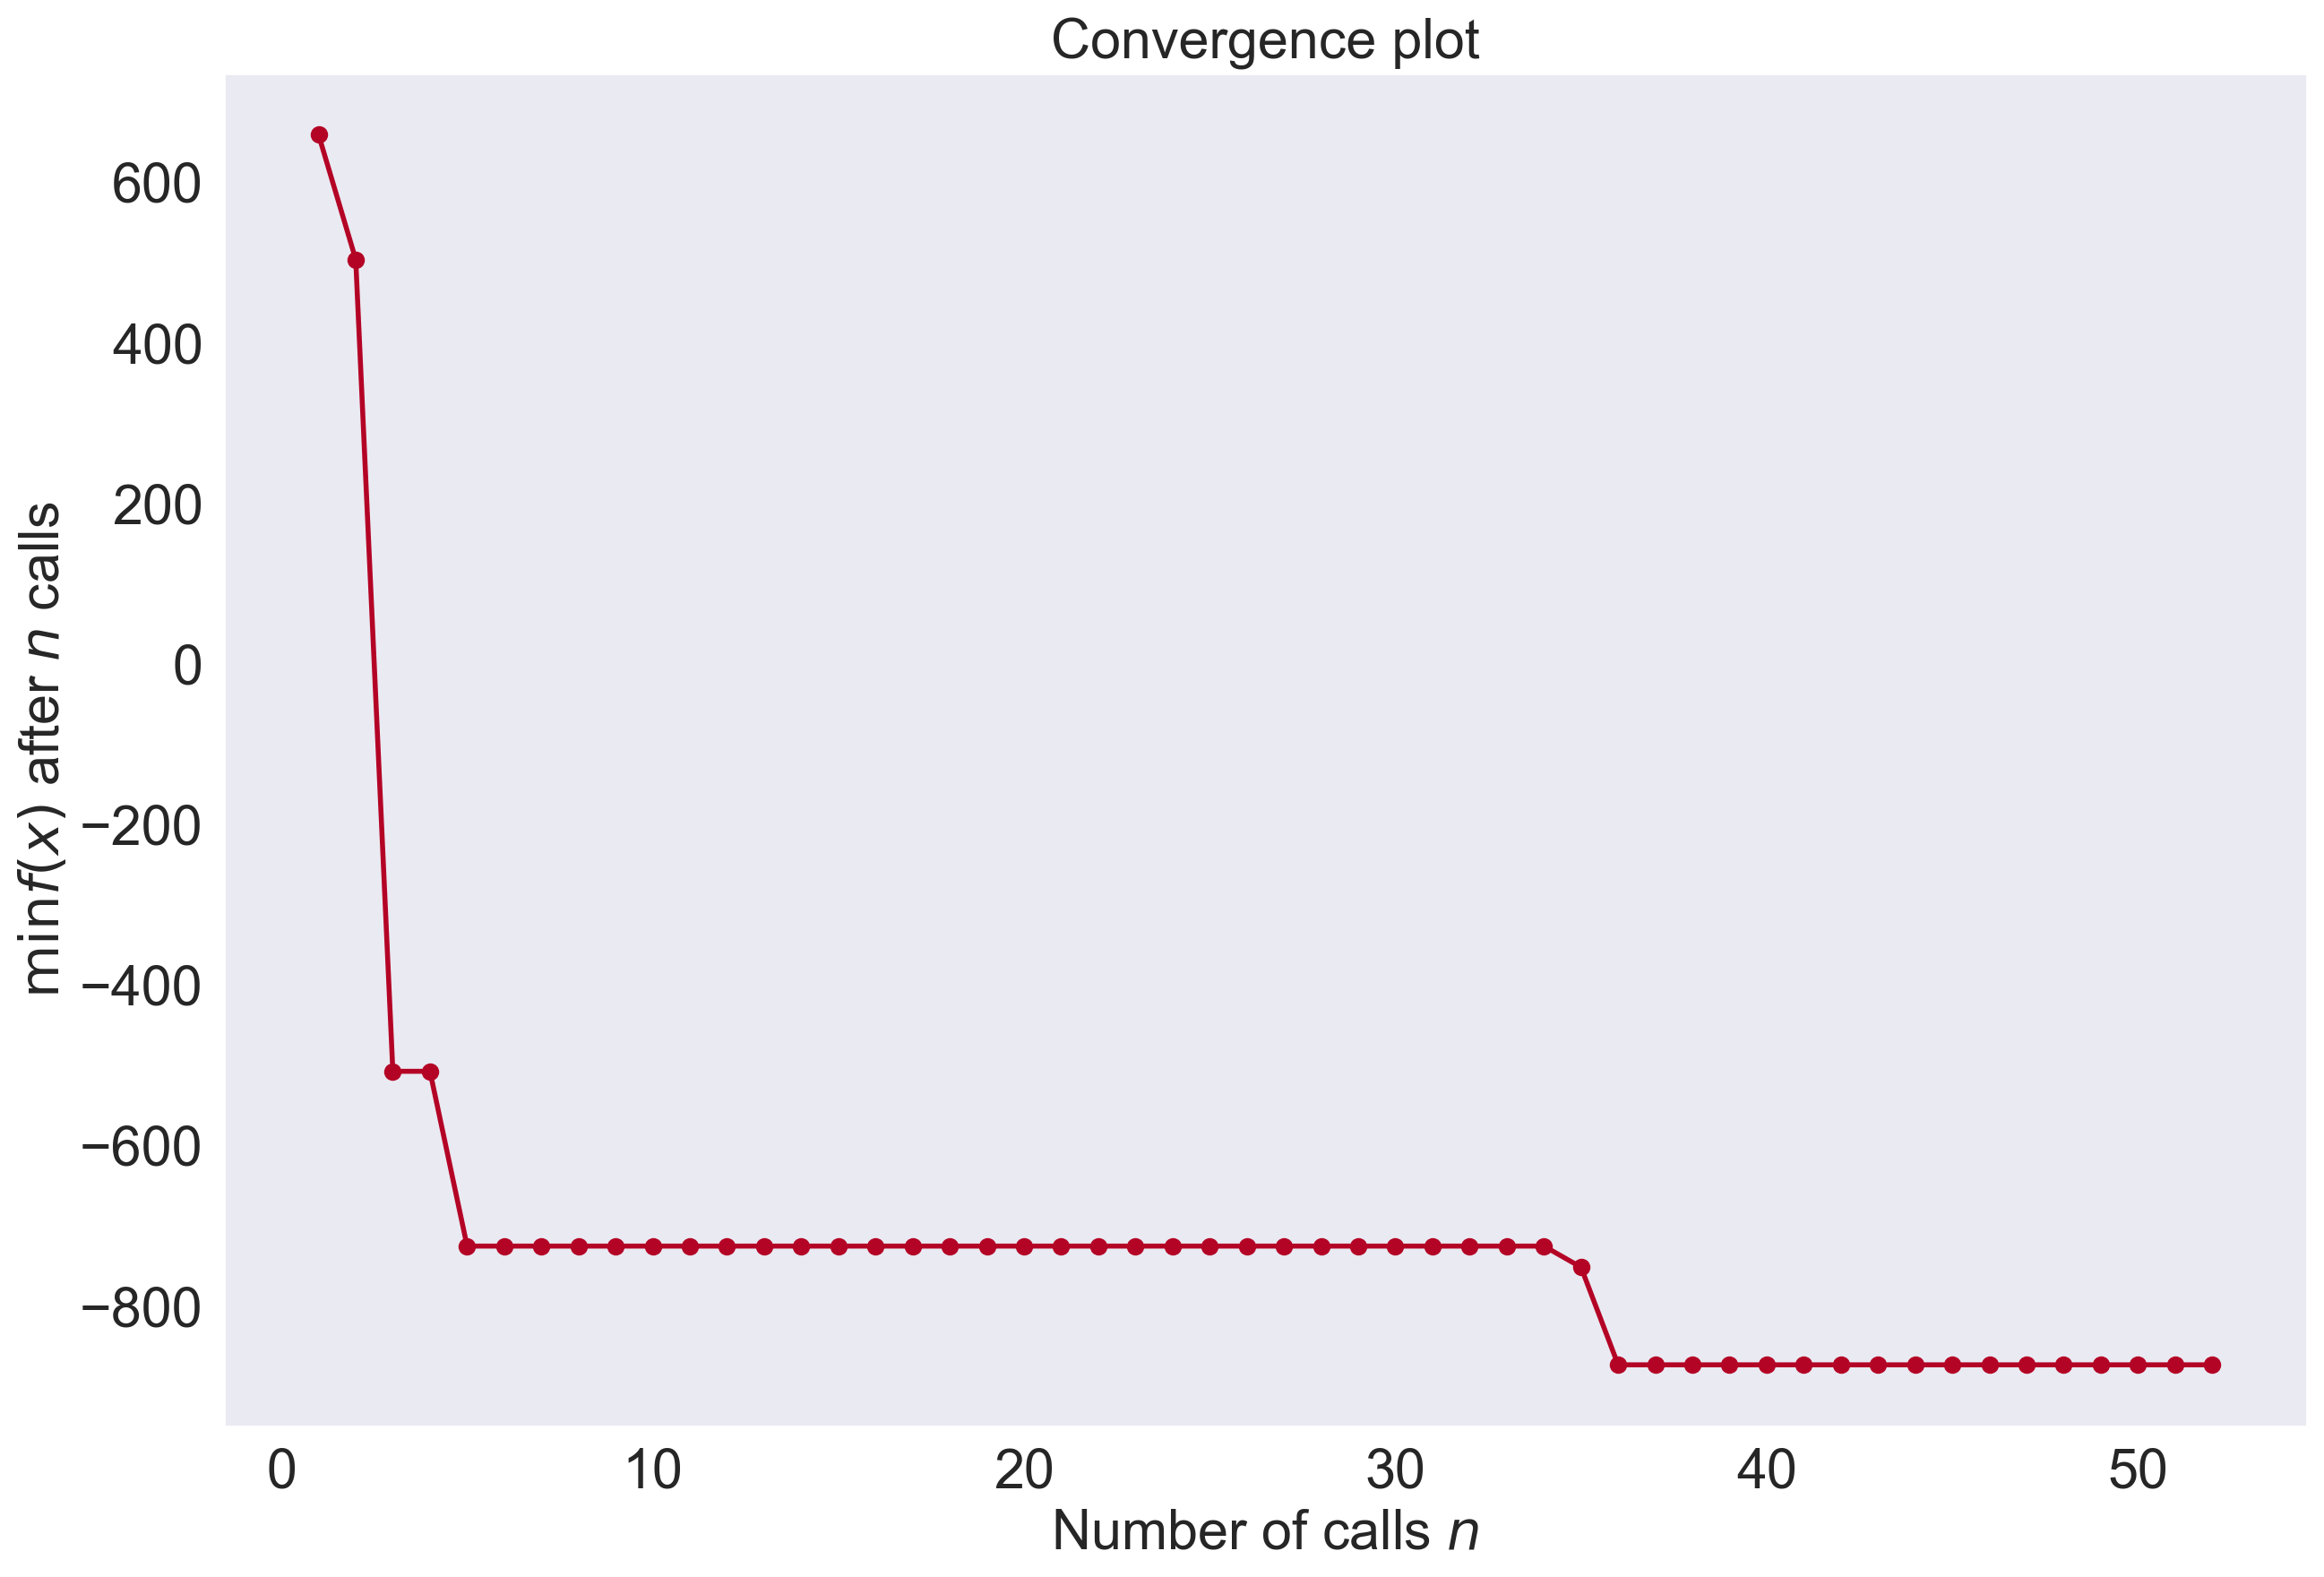

In [10]:
_ = plot_convergence(results, best_result)

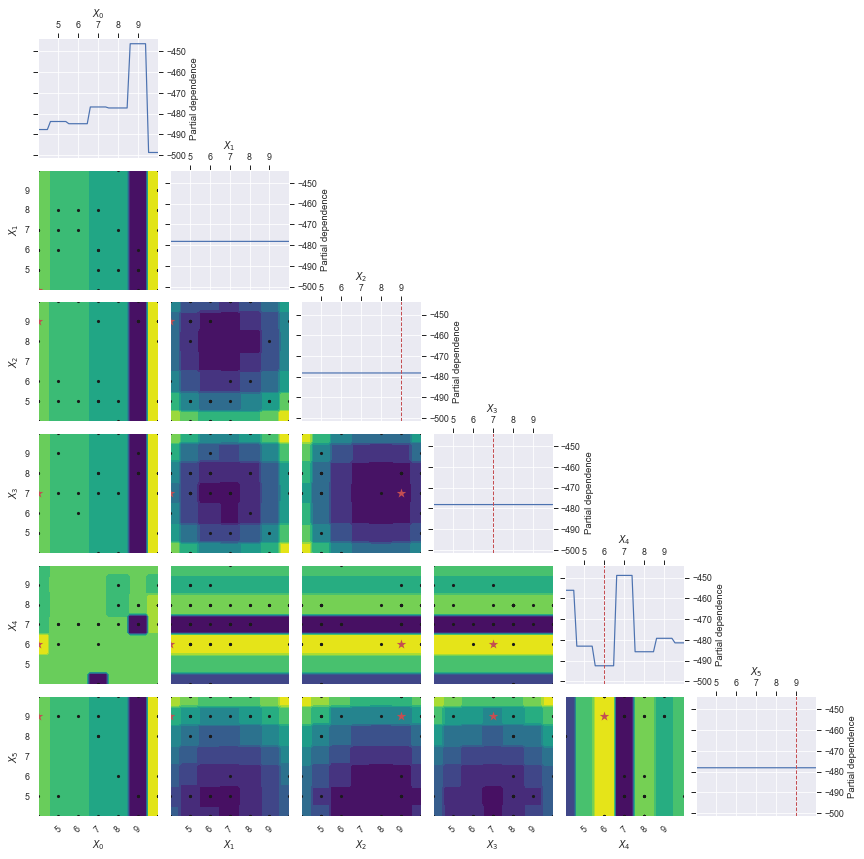

In [11]:
from skopt.plots import plot_objective


_ = plot_objective(best_result)